# Custom Models in pycalphad: Viscosity

## Viscosity Model Background

We are going to take a CALPHAD-based property model from the literature and use it to predict the viscosity of Al-Cu-Zr liquids.

For a binary alloy liquid under small undercooling, Gąsior suggested an entropy model of the form
$$\eta = (\sum_i x_i \eta_i ) (1 - 2\frac{S_{ex}}{R})$$

where $\eta_i$ is the viscosity of the element $i$, $x_i$ is the mole fraction, $S_{ex}$ is the excess entropy, and $R$ is the gas constant.

For more details on this model, see 

1. M.E. Trybula, T. Gancarz, W. Gąsior, *Density, surface tension and viscosity of liquid binary Al-Zn and ternary Al-Li-Zn alloys*, Fluid Phase Equilibria 421 (2016) 39-48, [doi:10.1016/j.fluid.2016.03.013](http://dx.doi.org/10.1016/j.fluid.2016.03.013).

2. Władysław Gąsior, *Viscosity modeling of binary alloys: Comparative studies*, Calphad 44 (2014) 119-128, [doi:10.1016/j.calphad.2013.10.007](http://dx.doi.org/10.1016/j.calphad.2013.10.007).

3. Chenyang Zhou, Cuiping Guo, Changrong Li, Zhenmin Du, *Thermodynamic assessment of the phase equilibria and prediction of glass-forming ability of the Al–Cu–Zr system*, Journal of Non-Crystalline Solids 461 (2017) 47-60, [doi:10.1016/j.jnoncrysol.2016.09.031](https://doi.org/10.1016/j.jnoncrysol.2016.09.031).

In [1]:
from pycalphad import Database

## TDB Parameters
We can calculate the excess entropy of the liquid using the Al-Cu-Zr thermodynamic database from Zhou et al.

We add three new parameters to describe the viscosity (in Pa-s) of the pure elements Al, Cu, and Zr:
```
   $ Viscosity test parameters
   PARAMETER ETA(LIQUID,AL;0) 2.98150E+02  +0.000281*EXP(12300/(8.3145*T));   6.00000E+03   
  N REF:0 !
   PARAMETER ETA(LIQUID,CU;0) 2.98150E+02  +0.000657*EXP(21500/(8.3145*T));   6.00000E+03   
  N REF:0 !
  PARAMETER ETA(LIQUID,ZR;0) 2.98150E+02  +4.74E-3 - 4.97E-6*(T-2128) ;   6.00000E+03   
    N REF:0 !
```

Great! However, if we try to load the database now, we will get an error. This is because `ETA` parameters are not supported by default in pycalphad, so we need to tell pycalphad's TDB parser that "ETA" should be on the list of supported parameter types.

In [2]:
try:
    dbf = Database('alcuzr-viscosity.tdb')
except Exception as e:
    print(e)

Failed while parsing:     PARAMETER ETA(LIQUID,AL;0) 2.98150E+02 +0.000281*EXP(12300/(8.3145*T)); 6.00000E+03 N REF:0 
Tokens: None
Expected {{'ELEMENT' W:(-/A-Za-z){1,2} W:(()-/-:A-Z_a-z) Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)') Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)') Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)') LineEnd} | {'SPECIES' W:(*+--9A-Z_a-z) [Suppress:('%')] Group:({{W:(A-Za-z){1,2} [Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)')]}}...) [Suppress:('/') W:(+-0-9)] LineEnd} | {'TYPE_DEFINITION' Suppress:(<SP><TAB><CR><LF>) !W:( !) SkipTo:(LineEnd)} | {'FUNCTION' W:(()-/-:A-Z_a-z) {{Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)') | [',']...} {{SkipTo:(';') Suppress:(';') [Suppress:(',')]... [Re:('[-+]?([0-9]+\.(?!([0-9]|[eE])))|([0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)')] Suppress:([(Yy)])}}... Suppress:([(Nn)])} [Suppress:(W:(-0-:A-

### Adding the `ETA` parameter to the TDB parser 

In [3]:
import pycalphad.io.tdb_keywords
pycalphad.io.tdb_keywords.TDB_PARAM_TYPES.append('ETA')

Now the database will load:

In [4]:
dbf = Database('alcuzr-viscosity.tdb')

## Writing the Custom Viscosity Model

Now that we have our `ETA` parameters in the database, we need to write a `Model` class to tell pycalphad how to compute viscosity. All custom models are subclasses of the pycalphad `Model` class.

When the `ViscosityModel` is constructed, the `build_phase` method is run and we need to construct the viscosity model after doing all the other initialization using a new method `build_viscosity`. The implementation of `build_viscosity` needs to do four things:
1. Query the Database for all the `ETA` parameters
2. Compute their weighted sum
3. Compute the excess entropy of the liquid
4. Plug all the values into the Gąsior equation and return the result

Since the `build_phase` method sets the attribute `viscosity` to the `ViscosityModel`, we can access the property using `viscosity` as the output in pycalphad caluclations.

In [5]:
from tinydb import where
from pycalphad import Model, variables as v

class ViscosityModel(Model):
    def build_phase(self, dbe):
        super(ViscosityModel, self).build_phase(dbe)
        self.viscosity = self.build_viscosity(dbe)

    def build_viscosity(self, dbe):
        if self.phase_name != 'LIQUID':
            raise ValueError('Viscosity is only defined for LIQUID phase')
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        # STEP 1
        eta_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'ETA') & \
            (where('constituent_array').test(self._array_validity))
        )
        # STEP 2
        eta = self.redlich_kister_sum(phase, param_search, eta_param_query)
        # STEP 3
        excess_energy = self.GM - self.models['ref'] - self.models['idmix']
        #liquid_mod = Model(dbe, self.components, self.phase_name)
        ## we only want the excess contributions to the entropy
        #del liquid_mod.models['ref']
        #del liquid_mod.models['idmix']
        excess_entropy = -excess_energy.diff(v.T)
        ks = 2
        # STEP 4
        result = eta * (1 - ks * excess_entropy / v.R)
        self.eta = eta
        return result

## Performing Calculations

Now we can create an instance of `ViscosityModel` for the liquid phase using the `Database` object we created earlier. We can verify this model has a `viscosity` attribute containing a symbolic expression for the viscosity.

In [6]:
mod = ViscosityModel(dbf, ['CU', 'ZR'], 'LIQUID')
print(mod.viscosity)

(0.000657*LIQUID0CU*2.71828182845905**(2585.84400745685*T**(-1.0)) + LIQUID0ZR*(0.00474 - 4.97e-06*(-2128.0 + T)))*(1 + 0.240543628600637*(LIQUID0CU*LIQUID0ZR*(392.8485 - 51.3121*log(T)) + (LIQUID0CU - LIQUID0ZR)*LIQUID0CU*LIQUID0ZR*(75.3798 - 9.6125*log(T)) + (LIQUID0CU - LIQUID0ZR)**2*LIQUID0CU*LIQUID0ZR*(-270.5305 + 36.8512*log(T)) + (LIQUID0CU - LIQUID0ZR)**3*LIQUID0CU*LIQUID0ZR*(105.895 - 13.6488*log(T)))/(LIQUID0CU + LIQUID0ZR))


Finally we calculate and plot the viscosity.

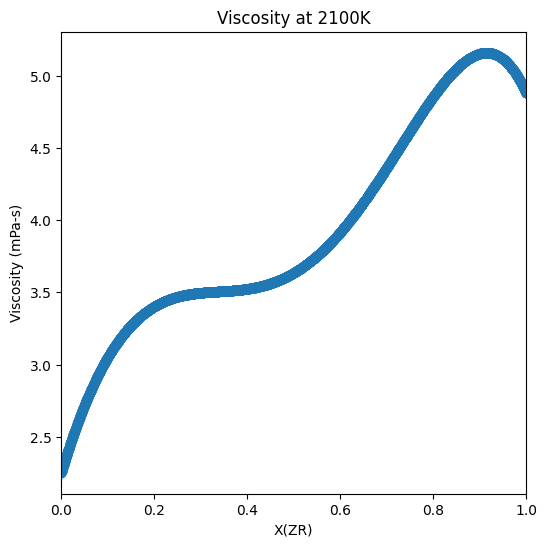

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import calculate

mod = ViscosityModel(dbf, ['CU', 'ZR'], 'LIQUID')

temp = 2100
# NOTICE: we need to tell pycalphad about our model for this phase
models = {'LIQUID': mod}
res = calculate(dbf, ['CU', 'ZR'], 'LIQUID', P=101325, T=temp, model=models, output='viscosity') 

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(res.X.sel(component='ZR'), 1000 * res.viscosity.values)
ax.set_xlabel('X(ZR)')
ax.set_ylabel('Viscosity (mPa-s)')
ax.set_xlim((0,1))
ax.set_title('Viscosity at {}K'.format(temp));

We repeat the calculation for Al-Cu.

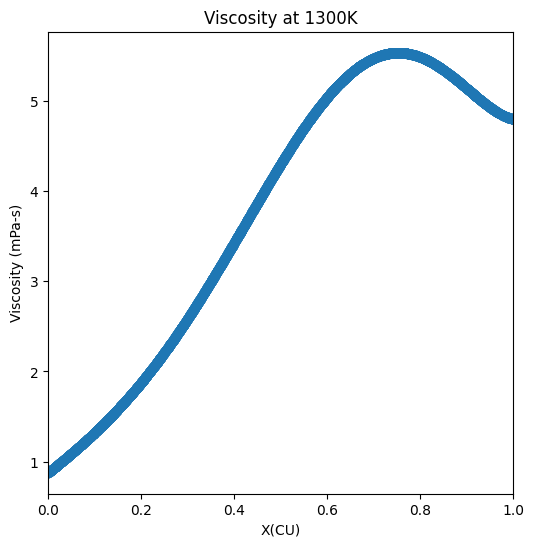

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import calculate

temp = 1300
models = {'LIQUID': ViscosityModel}  # we can also use Model class
res = calculate(dbf, ['CU', 'AL'], 'LIQUID', P=101325, T=temp, model=models, output='viscosity')

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(res.X.sel(component='CU'), 1000 * res.viscosity.values)
ax.set_xlabel('X(CU)')
ax.set_ylabel('Viscosity (mPa-s)')
ax.set_xlim((0,1))
ax.set_title('Viscosity at {}K'.format(temp));